In [18]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2


In [19]:
data_dir = "data/base_dataset/"
model_name = "alexnet"

num_classes = 6

batch_size = 128

num_epochs = 100
feature_extract = True

In [20]:
Tr_Loss = []
Tr_Accuracy = []
Val_Loss = []
Val_Accuracy = []

def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    for epoch in range(num_epochs):
        scheduler.step()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        _, preds = torch.max(outputs, 1)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            if phase == 'train':
                Tr_Loss.append(epoch_loss)
                Tr_Accuracy.append(epoch_acc)
            else:
                Val_Loss.append(epoch_loss)
                Val_Accuracy.append(epoch_acc)
                
            print('{} Loss: {:.4f} Acc: {:.4f} Lr: {}'.format(phase, epoch_loss, epoch_acc, optimizer.param_groups[0]['lr']))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [21]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [22]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 150
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [23]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'validation']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'validation']}

image_datasets

Initializing Datasets and Dataloaders...


{'train': Dataset ImageFolder
     Number of datapoints: 14034
     Root location: data/base_dataset/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'validation': Dataset ImageFolder
     Number of datapoints: 3000
     Root location: data/base_dataset/validation
     StandardTransform
 Transform: Compose(
                Resize(size=224, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [25]:
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.01, momentum=0.7)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [26]:
criterion = nn.CrossEntropyLoss()

model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

C:\Users\carlab\Anaconda3\envs\py_ab\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 0/99
----------
train Loss: 0.4722 Acc: 0.8254 Lr: 0.01
validation Loss: 0.2687 Acc: 0.8983 Lr: 0.01

Epoch 1/99
----------
train Loss: 0.4078 Acc: 0.8479 Lr: 0.01
validation Loss: 0.2516 Acc: 0.9037 Lr: 0.01

Epoch 2/99
----------
train Loss: 0.4011 Acc: 0.8537 Lr: 0.01
validation Loss: 0.2401 Acc: 0.9077 Lr: 0.01

Epoch 3/99
----------
train Loss: 0.3930 Acc: 0.8578 Lr: 0.01
validation Loss: 0.2511 Acc: 0.9043 Lr: 0.01

Epoch 4/99
----------
train Loss: 0.3775 Acc: 0.8547 Lr: 0.01
validation Loss: 0.2530 Acc: 0.9117 Lr: 0.01

Epoch 5/99
----------
train Loss: 0.3632 Acc: 0.8662 Lr: 0.01
validation Loss: 0.2529 Acc: 0.9007 Lr: 0.01

Epoch 6/99
----------
train Loss: 0.3700 Acc: 0.8606 Lr: 0.01
validation Loss: 0.2312 Acc: 0.9143 Lr: 0.01

Epoch 7/99
----------
train Loss: 0.3617 Acc: 0.8640 Lr: 0.01
validation Loss: 0.2246 Acc: 0.9210 Lr: 0.01

Epoch 8/99
----------
train Loss: 0.3575 Acc: 0.8673 Lr: 0.01
validation Loss: 0.2489 Acc: 0.9093 Lr: 0.01

Epoch 9/99
----------
train 

validation Loss: 0.2132 Acc: 0.9180 Lr: 1.0000000000000002e-06

Epoch 71/99
----------
train Loss: 0.3131 Acc: 0.8814 Lr: 1.0000000000000002e-06
validation Loss: 0.2132 Acc: 0.9180 Lr: 1.0000000000000002e-06

Epoch 72/99
----------
train Loss: 0.3067 Acc: 0.8850 Lr: 1.0000000000000002e-06
validation Loss: 0.2132 Acc: 0.9180 Lr: 1.0000000000000002e-06

Epoch 73/99
----------
train Loss: 0.3160 Acc: 0.8814 Lr: 1.0000000000000002e-06
validation Loss: 0.2132 Acc: 0.9180 Lr: 1.0000000000000002e-06

Epoch 74/99
----------
train Loss: 0.3103 Acc: 0.8827 Lr: 1.0000000000000002e-07
validation Loss: 0.2132 Acc: 0.9180 Lr: 1.0000000000000002e-07

Epoch 75/99
----------
train Loss: 0.3101 Acc: 0.8826 Lr: 1.0000000000000002e-07
validation Loss: 0.2132 Acc: 0.9180 Lr: 1.0000000000000002e-07

Epoch 76/99
----------
train Loss: 0.3097 Acc: 0.8844 Lr: 1.0000000000000002e-07
validation Loss: 0.2132 Acc: 0.9180 Lr: 1.0000000000000002e-07

Epoch 77/99
----------
train Loss: 0.3052 Acc: 0.8840 Lr: 1.000000

TypeError: cannot unpack non-iterable NoneType object

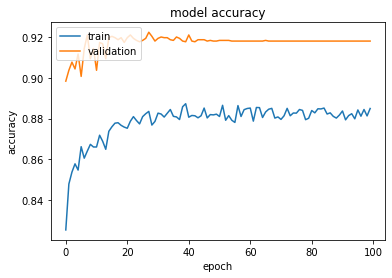

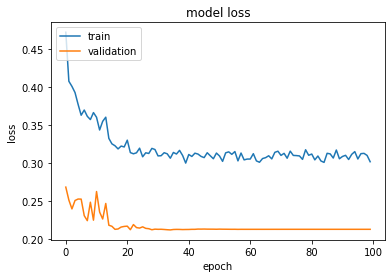

In [27]:
#Accuracy
plt.plot(Tr_Accuracy)
plt.plot(Val_Accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(Tr_Loss)
plt.plot(Val_Loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [28]:
Path = "Alex_BaseData_AdaptiveLearningRate.pth"
torch.save(model_ft.state_dict(), Path)

In [29]:
model = model_ft.load_state_dict(torch.load("Alex_BaseData_AdaptiveLearningRate.pth"))
model = model_ft.eval().to(device)

In [30]:
transform = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [31]:
def get_predictions(model, Loader):
    A_Preds = torch.tensor([]).to(device = device)
    
    for batch in Loader:
        images, labels = batch

        images = images.to(device = device)
        labels = labels.to(device = device)
     
        pred = model(images)
        A_Preds = torch.cat((A_Preds, pred), dim = 0)
        
        return A_Preds

In [33]:
Test_Dataset = datasets.ImageFolder('data/base_dataset/test/', transform)

In [34]:
Pred_Loader = torch.utils.data.DataLoader(Test_Dataset, batch_size = 10, shuffle=True)

In [35]:
def get_num_correct (preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [45]:
classes = 'buildings','forest','glacier','mountains','sea','street'

In [37]:
from sklearn.metrics import confusion_matrix

predlist=torch.zeros(0,dtype=torch.long).to(device)
lbllist=torch.zeros(0,dtype=torch.long).to(device)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(Pred_Loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs).to(device)
        _, preds = torch.max(outputs, 1)

        predlist=torch.cat([predlist,preds.view(-1)])
        lbllist=torch.cat([lbllist,classes.view(-1)])

conf_mat = confusion_matrix(lbllist.cpu().data.numpy(), predlist.cpu().data.numpy())

class_accuracy = 100 * conf_mat.diagonal() / conf_mat.sum(1)

print(conf_mat)

[[ 964    5    4    5   11  155]
 [   3 1139    2    7    5   10]
 [   4    7 1064  189   61    5]
 [   4   13  157 1027   92    4]
 [  11    6   41   72  992    6]
 [  90   16    8    9   17 1096]]


In [42]:
from PIL import Image

filename = ("data/base_dataset/Test/buildings/5.jpg")
input_image = Image.open(filename)

In [43]:
preprocess = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

input_tensor = preprocess(input_image).to(device)
input_batch = input_tensor.unsqueeze(0)
input_batch.shape

torch.Size([1, 3, 224, 224])

tensor([9.9759e-01, 4.6268e-07, 6.1922e-06, 2.8496e-08, 4.3823e-05, 2.3596e-03],
       device='cuda:0')
tensor(0, device='cuda:0')
buildings


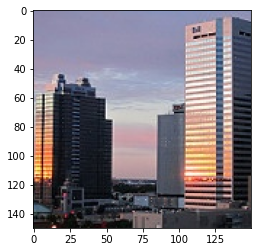

In [46]:
with torch.no_grad():
    output = model(input_batch)

per = torch.nn.functional.softmax(output[0], dim=0)
index = torch.argmax(per, dim = 0)

plt.imshow(input_image)
print(per)
print(index)
print(classes[index])